![](https://i.pinimg.com/originals/09/53/81/0953813004d675ca814403fbb649f8b7.png)

## Goals
- Create a machine learning algorithm to predict if a patient has diabetes or not  

## Conclusions
- Major Takeaways: 
    - The patient's Glucose level has the highest impact on becoming diabetic
    - Other features, such as high BMI, can increase the risk.  
    
- Final model to predict a patient's diagnosis of diabetes: Random Forest

| Model    | RandomForest | (max_depth=5, random_state=123)             | ['Glucose','Age','BMI','insulin_glucose_cluster','DiabetesPedigreeFunction'] |
|----------|--------------|---------------------------------------------|------------------------------------------------------------------------------|
| DF       | Accuracy     | Recall on True Positive (actually diabetic) | Precision on True Positive (actually diabetic)                               |
| Train    | 86%          | 69%                                         | 86%                                                                          |
| Validate | 79%          | 62%                                         | 76%                                                                          |
| Test     | 75%          | 57%                                         | 57%                                                                          |

- Next Steps:
    - create more features with clustering/binning
    - statistically test more features

## How to Reproduce:
- Go over the Readme.md file in the repository of this project [here](https://github.com/ThompsonBethany01/Predicting-Diabetes-Onset).
- Download Data_Analysis.ipynb, Prepare.py, and the dataset in your working directory.
- Run this notebook.

## Thought Process
The predictive variable is the patient being diabetic or not, 0 or 1, making it a classification problem. With a classification problem:
- we create algorithms based on the labeled outcome variable
- this produces a decision rule to classify future data with
- we generalize the trends/patterns in the data to predict the future/unseen data

# Table of Contents <a class="anchor" id="top"></a>
1. [Acquire](#acquire)
2. [Prepare](#prepare)
3. [Explore](#explore)
4. [Modeling](#model)
5. [Final Conclusions](#fin)

In [1]:
# initial imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#import modules
import Prepare
# import Model

# Acquire <a class="anchor" id="acquire"></a>
Dataset from UCI Machine Learning via Kaggle [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database) saved in .csv file  
#### Steps:
- read csv file into df
- summarize data
- create data dictionary

In [2]:
# needs saved csv file to continue
df = pd.read_csv('diabetes.csv')

In [3]:
print('The dataframe has', df.shape[0], 'rows and', df.shape[1], 'columns.')

The dataframe has 768 rows and 9 columns.


In [4]:
print('The columns are named: ', df.columns.to_list())

The columns are named:  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


In [5]:
# What are the data types and null counts for each column?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### What do we learn from df.info()?
- there are no null values
- most columns are integers
- BMI and DPF are decimals (floats)

In [6]:
# what is the distribution of the numeric columns? (All columns)
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### What do we learn from df.describe()?
- greatest variation in Insluin
- Many features have a minimum of 0. Is this feasible?
    - someone can not have 0 for BMI, Glucose, or BloodPressure
- Insulin maximum is 846, is this possible or an anamoly cause by a typo? Need to research.

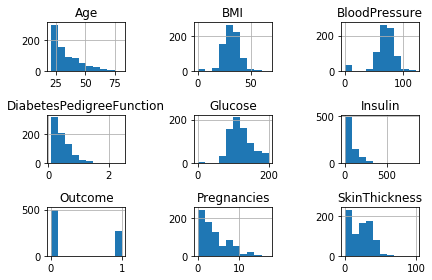

In [7]:
# looking at the distribution of features all at once simply with df.hist()
df.hist()
plt.tight_layout()

### Takeaways
768 observations  
- 8 columns and 1 predictive column as diabetic or not  

All numeric values, integers or floats  
- average diabetic diagnosis is 0, non-diabetic  
- all continuous features except pregnancies and outcome which are discrete  

No null values  
- observations with 0 for values that cannot be, such as BMI and Blood Pressure, have 0 for multiple features  
    - could be null values that were replaced with 0

[Table of Contents](#top)

# Prepare <a class="anchor" id="prepare"></a>
For Exploration:
- create new features by bining demographics  or clustering
    - age into 20s, 30s, etc
    - bmi into low, middle, high
    - blood pressure into low, good, high
    - create features based on clustering

For Modeling:
- split into train, valideate, test
- scale the data - fitting on train df only
- determine if outliers/anomalies to remove (after MVP complete)

## Prepare.py Module contains functions used below
### Prepare.prep_df
- replaces values of 0 in...
    - BMI
    - Glucose
    - BloodPressure  
   with the mean of the feature
   
- bins features with pd.qcut(cuts features into even bins based on number of bins specified)
    - age
    - bmi
    - bloodpressure

- creates feature for patient having both high bloodpressure and bmi

In [8]:
# prepping df before split with function
df = Prepare.prep_df(df)

In [9]:
# quality control, checking the df looks accurate
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_bins,bmi_bins,bp_bins,high_bmi_bp
0,6,148.0,72.0,35,0,33.6,0.627,50,1,4,2,2,True
1,1,85.0,66.0,29,0,26.6,0.351,31,0,3,1,1,False
2,8,183.0,64.0,0,0,23.3,0.672,32,1,3,1,1,False
3,1,89.0,66.0,23,94,28.1,0.167,21,0,1,1,1,False
4,0,137.0,40.0,35,168,43.1,2.288,33,1,3,3,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48,180,32.9,0.171,63,0,4,2,2,True
764,2,122.0,70.0,27,0,36.8,0.340,27,0,2,3,2,False
765,5,121.0,72.0,23,112,26.2,0.245,30,0,3,1,2,False
766,1,126.0,60.0,0,0,30.1,0.349,47,1,4,2,1,True


### Prepare.split_df
Splits Data into
- 70% train
- 20% validate
- 10% test  

printing the returned shape of the split df

In [10]:
# splitting df with function
train, validate, test = Prepare.split_df(df)

train shape:  (538, 13) , validate shape:  (153, 13) , test shape:  (77, 13)

train percent:  70.0 , validate percent:  20.0 , test percent:  10.0


In [11]:
# quality control, checking train df looks like the df above but with smaller mixed index
train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_bins,bmi_bins,bp_bins,high_bmi_bp
279,2,108.0,62.000000,10,278,25.3,0.881,22,0,1,1,1,False
614,11,138.0,74.000000,26,144,36.1,0.557,50,1,4,3,2,False
740,11,120.0,80.000000,37,150,42.3,0.785,48,1,4,3,3,True
113,4,76.0,62.000000,0,0,34.0,0.391,25,0,2,2,1,True
405,2,123.0,48.000000,32,165,42.1,0.520,26,0,2,3,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,0,104.0,64.000000,37,64,33.6,0.510,22,1,1,2,1,True
683,4,125.0,80.000000,0,0,32.3,0.536,27,1,2,2,3,True
624,2,108.0,64.000000,0,0,30.8,0.158,21,0,1,2,1,True
453,2,119.0,69.105469,0,0,19.6,0.832,72,0,4,1,2,False


### Prepare.scale_dfs
- Scaling the Data Using Min-Max Scaler
- transforms the range of data points to 0 - 1
- fits scaler to train only, then transforms on all 3 dfs
- returns the split dfs scaled

In [12]:
# calling split df function
X_train_scaled, X_validate_scaled, X_test_scaled = Prepare.scale_dfs(train, validate, test, 'Outcome')

In [13]:
# quality control, does df look the same as train but with scalled values?
X_train_scaled

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,age_bins,bmi_bins,bp_bins,high_bmi_bp
279,0.117647,0.412903,0.387755,0.101010,0.328605,0.172330,0.340899,0.019608,0.000000,0.0,0.0,0.0
614,0.647059,0.606452,0.510204,0.262626,0.170213,0.434466,0.202141,0.568627,1.000000,1.0,0.5,0.0
740,0.647059,0.490323,0.571429,0.373737,0.177305,0.584951,0.299786,0.529412,1.000000,1.0,1.0,1.0
113,0.235294,0.206452,0.387755,0.000000,0.000000,0.383495,0.131049,0.078431,0.333333,0.5,0.0,1.0
405,0.117647,0.509677,0.244898,0.323232,0.195035,0.580097,0.186296,0.098039,0.333333,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
448,0.000000,0.387097,0.408163,0.373737,0.075650,0.373786,0.182013,0.019608,0.000000,0.5,0.0,1.0
683,0.235294,0.522581,0.571429,0.000000,0.000000,0.342233,0.193148,0.117647,0.333333,0.5,1.0,1.0
624,0.117647,0.412903,0.408163,0.000000,0.000000,0.305825,0.031263,0.000000,0.000000,0.5,0.0,1.0
453,0.117647,0.483871,0.460260,0.000000,0.000000,0.033981,0.319914,1.000000,1.000000,0.0,0.5,0.0


### Prepare.create_clusters
- Creating Clusters on Scaled Data
- multitude of parameters allow one function to create any cluster
    - train, validate, and test scaled dfs to fit the cluster model to train only, then transform on all dfs
    - train, validate, test to add the clusters to the unscaled dfs as well for exploration
    - features = what to create the clusters on
    - columns = name of the columns when adding the clusters to the dfs
    - n = number of groups within the cluster to make
    - cluster = name of the original cluster before splitting into dummies
    
#### For each cluster:
1. visualize the number to set for n with elbow test
2. call the function with n set from elbow test

### Age and BMI Cluster

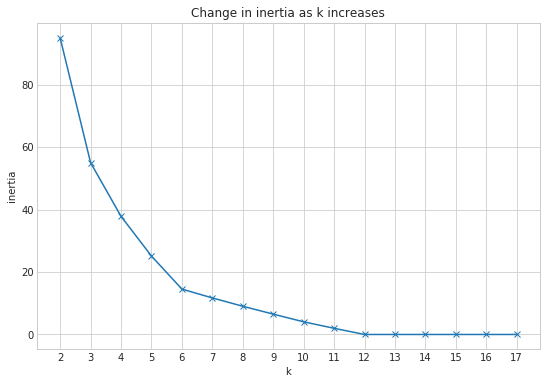

In [14]:
# elbow test to determine n
from sklearn.cluster import KMeans

# features to predict cluster on, only fitting model on X(train)
X = X_train_scaled[['age_bins','bmi_bins']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 18)}).plot(marker='x')
    plt.xticks(range(2, 18))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    
# will start with 4 clusters

In [15]:
# creating cluster with function from Prepare.py

features = ['age_bins','bmi_bins']
columns = ['age_bmi_cluster1','age_bmi_cluster2','age_bmi_cluster3','age_bmi_cluster4']
n = 4
cluster = 'age_bmi_cluster'

X_train_scaled, X_validate_scaled, X_test_scaled, train, validate, test = Prepare.create_clusters(X_train_scaled, X_validate_scaled, X_test_scaled, train, validate, test, features, n, columns, cluster)

### Pregnancy Cluster

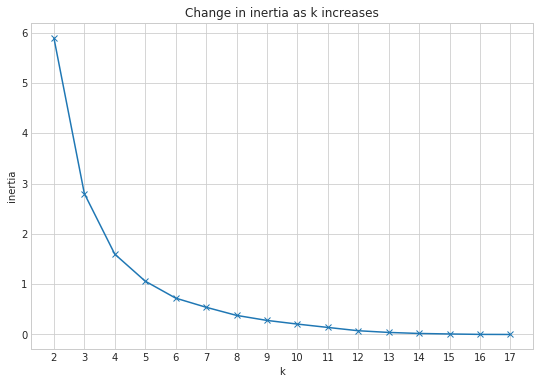

In [16]:
# feature to create cluster on, only fitting model on X(train)
X = X_train_scaled[['Pregnancies']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 18)}).plot(marker='x')
    plt.xticks(range(2, 18))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    
# will start with 4 clusters

In [17]:
# creating cluster with function from Prepare.py

features = ['Pregnancies']
columns = ['pregnancy_cluster1','pregnancy_cluster2','pregnancy_cluster3','pregnancy_cluster4']
n = 4
cluster = 'pregnancy_cluster'

X_train_scaled, X_validate_scaled, X_test_scaled, train, validate, test = Prepare.create_clusters(X_train_scaled, X_validate_scaled, X_test_scaled, train, validate, test, features, n, columns, cluster)

### Insulin and Glucose Cluster

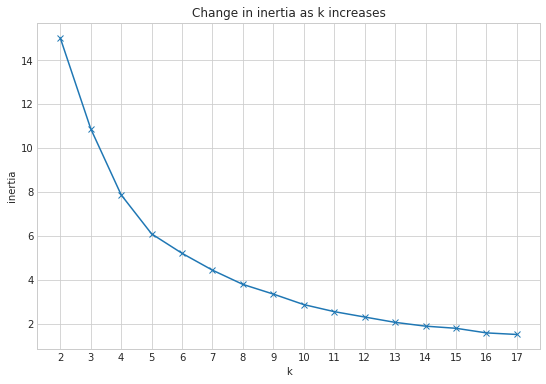

In [18]:
# features to predict cluster on, only fitting model on X(train)
X = X_train_scaled[['Insulin','Glucose']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 18)}).plot(marker='x')
    plt.xticks(range(2, 18))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    
# will start with 5 clusters

In [19]:
# creating cluster with function from Prepare.py

features = ['Insulin','Glucose']
columns = ['insulin_glucose_cluster1','insulin_glucose_cluster2','insulin_glucose_cluster3','insulin_glucose_cluster4','insulin_glucose_cluster5']
n = 5
cluster = 'insulin_glucose_cluster'

X_train_scaled, X_validate_scaled, X_test_scaled, train, validate, test = Prepare.create_clusters(X_train_scaled, X_validate_scaled, X_test_scaled, train, validate, test, features, n, columns, cluster)

In [20]:
# quality control, do we see the clusters added to the end of train scaled df?
X_train_scaled

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,age_bins,bmi_bins,...,pregnancy_cluster1,pregnancy_cluster2,pregnancy_cluster3,pregnancy_cluster4,insulin_glucose_cluster,insulin_glucose_cluster1,insulin_glucose_cluster2,insulin_glucose_cluster3,insulin_glucose_cluster4,insulin_glucose_cluster5
279,0.117647,0.412903,0.387755,0.101010,0.328605,0.172330,0.340899,0.019608,0.000000,0.0,...,1,0,0,0,4,0,0,0,0,1
614,0.647059,0.606452,0.510204,0.262626,0.170213,0.434466,0.202141,0.568627,1.000000,1.0,...,0,0,1,0,4,0,0,0,0,1
740,0.647059,0.490323,0.571429,0.373737,0.177305,0.584951,0.299786,0.529412,1.000000,1.0,...,0,0,1,0,4,0,0,0,0,1
113,0.235294,0.206452,0.387755,0.000000,0.000000,0.383495,0.131049,0.078431,0.333333,0.5,...,0,0,0,1,0,1,0,0,0,0
405,0.117647,0.509677,0.244898,0.323232,0.195035,0.580097,0.186296,0.098039,0.333333,1.0,...,1,0,0,0,4,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,0.000000,0.387097,0.408163,0.373737,0.075650,0.373786,0.182013,0.019608,0.000000,0.5,...,1,0,0,0,0,1,0,0,0,0
683,0.235294,0.522581,0.571429,0.000000,0.000000,0.342233,0.193148,0.117647,0.333333,0.5,...,0,0,0,1,2,0,0,1,0,0
624,0.117647,0.412903,0.408163,0.000000,0.000000,0.305825,0.031263,0.000000,0.000000,0.5,...,1,0,0,0,2,0,0,1,0,0
453,0.117647,0.483871,0.460260,0.000000,0.000000,0.033981,0.319914,1.000000,1.000000,0.0,...,1,0,0,0,2,0,0,1,0,0


### Takeaways
- imputed 0 values that could not be 0 with the mean
- created features based on binning
- split the data for exploration and modeling
- scaled the data based on split train df
- created clusters based on split scaled train df

### Next Steps
- are there other clusters that could be more significant in modeling?
- are there outliers/anomalies to deal with?

[Table of Contents](#top)

# Explore <a class="anchor" id="explore"></a>
- determine trends in patient being diabetic or not
    - X feature(s) vs. Outcome
- test the significance with hypothesis testing, such as with:
    - t-test
    - chi-squared contingancy table
    - ANOVA test
- explore interaction of independent features to determine what clusters to create
- visualize clusters created

Text(0, 0.5, 'Count of Patients')

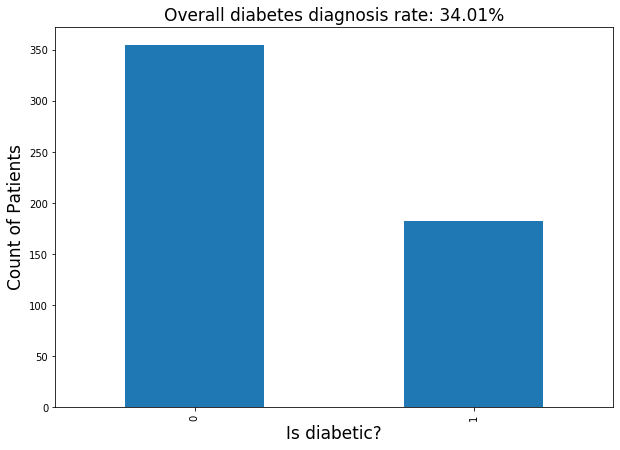

In [21]:
# visualizing distribution of Y feature (predictive variable)
plt.figure(figsize=(10,7))
train.Outcome.value_counts().sort_index().plot.bar()
diabetic_rate = train.Outcome.mean()
plt.title(f"Overall diabetes diagnosis rate: {diabetic_rate:.2%}", size=17)
plt.xlabel('Is diabetic?', size=17)
plt.ylabel('Count of Patients', size=17)

### Overall, most patients are not diagnosed with diabetes.

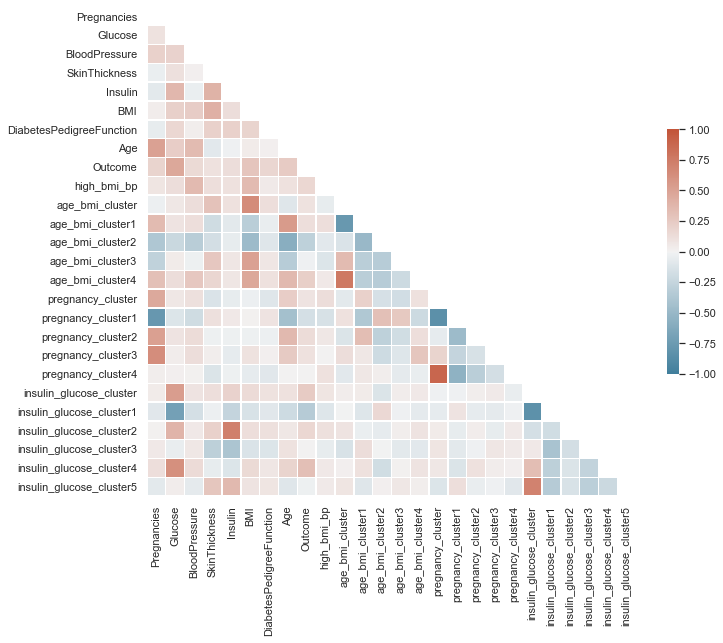

In [22]:
# visualizing overall linear correlation of all features
corr = train.corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)

### Outcome has strongest correlation with Glucose, which is also reflected later in model. This feature had the strongest importance for all modeling algorithms.
#### Note: Features can have non-linear correlation, which would not be captured in this heatmap.

## Looking at Independent Features vs. Diabetic Outcome
### Diagnosis Rate within Subgroups of Age, BMI, and BP Bins

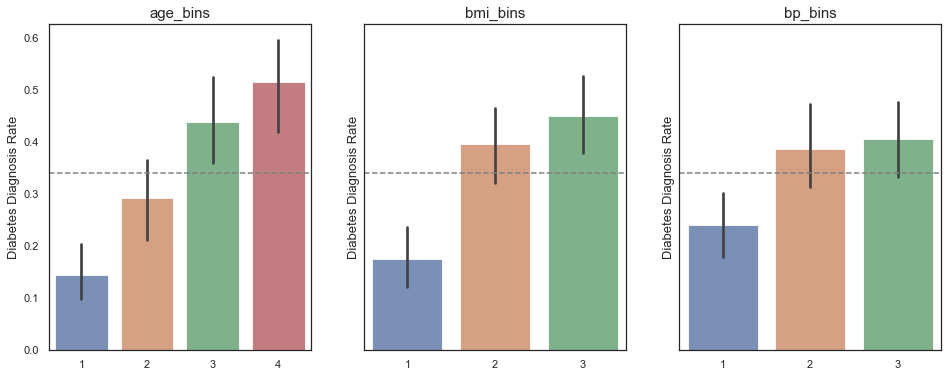

In [23]:
# visualizing subgroups within feature bins, is there a significant difference of diabetic diagnosis?
# categorical features we can compare
features = ['age_bins', 'bmi_bins', 'bp_bins']

# overall diagnosis of diabetes on whole train df
diabetic_rate = train.Outcome.mean()

# plotting subgroups diagnosis rate and comparing to overal with dashed line
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'Outcome', data=train, ax=ax[i], alpha=.8)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Diabetes Diagnosis Rate', size=13)
    ax[i].set_title(feature, size=15)
    ax[i].axhline(diabetic_rate, ls='--', color='grey')

Notes:
- Age bins have higher diagnosis rates in the older bins.
- BMI bins have higher diagnosis rates at higher BMI
- BloodPressure bins have higher diagnosis rates at higher bloodpressure

## Statistically Testing these Hypothesis Seen in Visuals

### Correlation Test
- do two samples have a linear relationship?
- null hypothesis is that there is no linear correlation between the two variables
- the correlation coefficient is a unitless continuous numerical measure between -1 and 1, where 1 = perfect correlation and -1 = perfect negative correlation

### Age vs. Diabetes Diagnosis
$H_O$: There is no significant correlation between age and diabetes diagnosis.   
$H_a$: Older populations correlate with a higher rate of diabetes (in female patients +21 with Pima Indian heritage).

Age average: 33.2 
Age median: 29.0


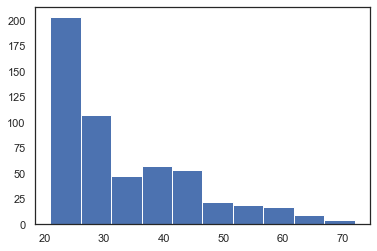

In [91]:
# not normally distributed, so we do not do a t-test
plt.hist(train.Age)
print('Age average:', round(train.Age.mean(),2), '\nAge median:', round(train.Age.median(),2))

In [95]:
from scipy import stats

x = train.Age
y = train.Outcome

corr, p = stats.pearsonr(x, y)
print('correlation coeeficient:', corr, '\n\np-value:', p)

correlation coeeficient: 0.24227877203905204 

p-value: 1.2588716946736375e-08


#### P is less than alpha (.01), we reject the null hypothesis.
There is a significant correlation between age and diagnosis rates of diabetes. The correlation coeeficient being a positive number tells us the rate increases as age increases.

### T-test
- Compare the mean for a specific subgroup against the population mean.
- One of the assumptions of the t-test is that the continuous variable is normally distributed. To check this, we can make a quick visualization.

### BMI vs. Diabetes Diagnosis
$H_O$: There is no significant difference between BMI and diabetes diagnosis.  
$H_a$: Populations with higher BMI have a significantly higher rate of diabetes (in female patients +21 with Pima Indian heritage).

## alpha = .01

BMI average: 32.39 
BMI median: 32.15


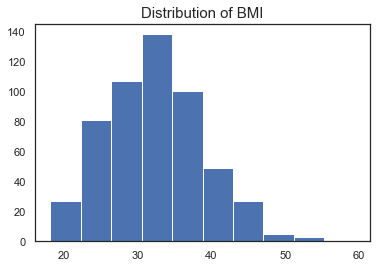

In [82]:
# is the continuous variable normally distributed?
plt.hist(train.BMI)
plt.title('Distribution of BMI', size=15)
print('BMI average:', round(train.BMI.mean(),2), '\nBMI median:', round(train.BMI.median(),2))

In [87]:
from math import sqrt

# tesing subgroup of bin 3 of BMI
top_BMI = train[train.bmi_bins == 3]

μ = train.Outcome.mean()
xbar = top_BMI.Outcome.mean()
s = top_BMI.Outcome.std()
n = top_BMI.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))
print('t-value:', round(t,4))
      
p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test
print('p-value:', round(p,4))

t-value: 2.9852
p-value: 0.0032


#### P is less than alpha (.01), we reject the null hypothesis.
Populations with higher BMI have a significantly higher rate of diabetes (in female patients +21 with Pima Indian heritage). This is specifically patients in the bmi_bins of 3, those with a BMI higher than 34.867.

### BloodPressure vs. Diabetes Diagnosis
$H_O$: There is no significant difference between age and diabetes diagnosis.  
$H_a$: Populations with higher blood pressure have a significantly higher rate of diabetes (in female patients +21 with Pima Indian heritage).

Blood Pressure average: 72.46 
Blood Pressure median: 72.0


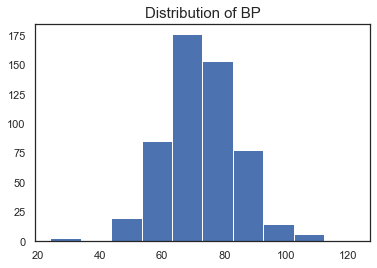

In [83]:
# is the continuous variable normally distributed?
plt.hist(train.BloodPressure)
plt.title('Distribution of BP', size=15)
print('Blood Pressure average:', round(train.BloodPressure.mean(),2), '\nBlood Pressure median:', round(train.BloodPressure.median(),2))

In [90]:
# tesing subgroup of bin 3 of BMI
top_BP = train[train.bp_bins == 3]

μ = train.Outcome.mean()
xbar = top_BP.Outcome.mean()
s = top_BP.Outcome.std()
n = top_BP.shape[0]
degf = n - 1
standard_error = s / sqrt(n)

t = (xbar - μ) / (s / sqrt(n))
print('t-value:', round(t,4))
      
p = stats.t(degf).sf(t) * 2 # *2 for two-tailed test
print('p-value:', round(p,4))

t-value: 1.7823
p-value: 0.0764


#### P is not lower than alpha(.01), we fail to reject the null hypothesis.
There is no significant difference between age and diabetes diagnosis. This is specific for patients in the bp_bin of 3. Could splitting the bins into smaller categories create a cluster that is significantly higher rates of diabetes?

### Diagnosis Rates Within Subgroups of Pregnancy Count

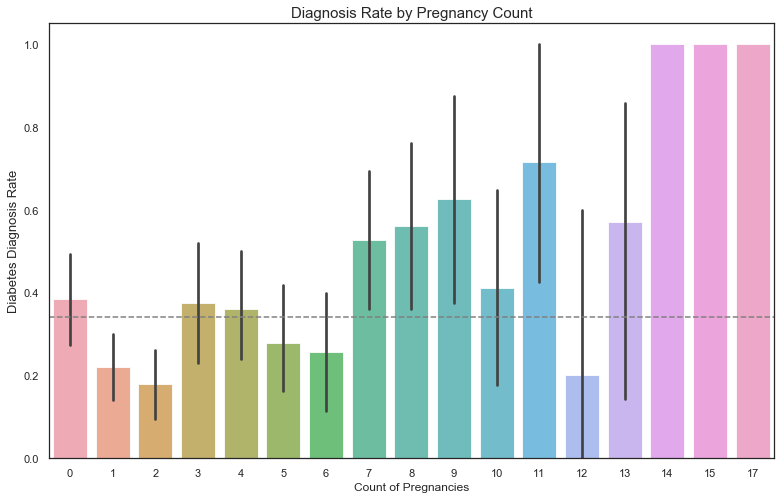

In [27]:
# overall diagnosis of diabetes on whole train df
diabetic_rate = train.Outcome.mean()

plt.figure(figsize=(13,8))

# plotting pregnancy count diagnosis rate and comparing to overall with dashed line
sns.barplot('Pregnancies', 'Outcome', data=train, alpha=.8)
plt.xlabel('Count of Pregnancies')
plt.ylabel('Diabetes Diagnosis Rate', size=13)
plt.title('Diagnosis Rate by Pregnancy Count', size=15)
plt.axhline(diabetic_rate, ls='--', color='grey')

In [28]:
# note the few amount of pregnancies at 10 and higher
train[train.Outcome == 1].Pregnancies.value_counts()

0     28
1     22
7     19
3     18
4     18
8     14
2     13
5     12
9     10
6      9
10     7
11     5
13     4
15     1
12     1
14     1
17     1
Name: Pregnancies, dtype: int64

### Count of Pregnancies vs. Diabetes Diagnosis - Correlation Test
$H_O$: There is no significant correlation between age and diabetes diagnosis.   
$H_a$: Older populations correlate with a higher rate of diabetes (in female patients +21 with Pima Indian heritage).

In [96]:
x = train.Pregnancies
y = train.Outcome

corr, p = stats.pearsonr(x, y)
print('correlation coeeficient:', corr, '\n\np-value:', p)

correlation coeeficient: 0.18789873853368913 

p-value: 1.1477773578019894e-05


#### P is less than alpha (.01), we reject the null hypothesis.
There is a significant correlation between count of pregnancies and diagnosis rates of diabetes. The correlation coefficient being a positive number tells us the rate increases as the count increases. Howver, you can see the correlation is not as strong as age, as the coefficient is .19 as opposed to .24 in age.

### Visualizing Interaction of Age and BMI Bins

Text(0.5, 1.0, 'Diabetes Diagnosis by Age and BMI Bins')

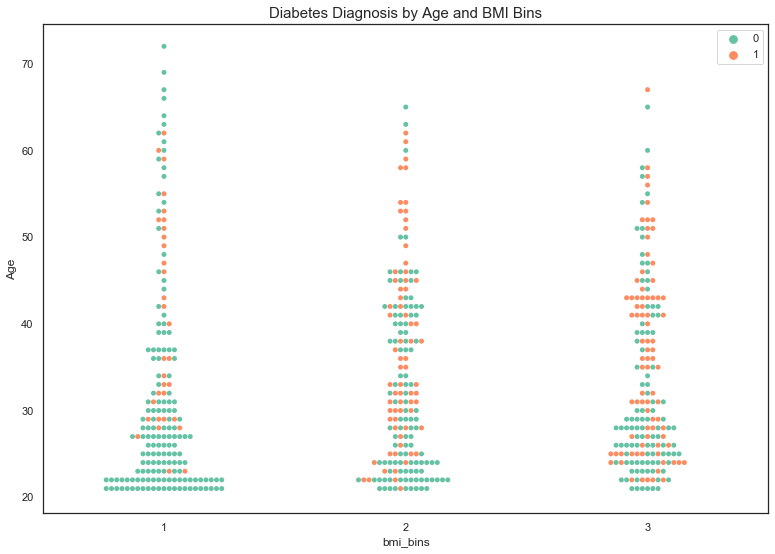

In [29]:
plt.figure(figsize=(13,9))
sns.swarmplot(x="bmi_bins", y="Age", data=train, hue="Outcome", palette="Set2")
plt.legend()
plt.title('Diabetes Diagnosis by Age and BMI Bins', size=15)

### Visualzing Interaction of Glucose and Insulin

Text(0.5, 1, 'Diabetes Diagnosis with BMI vs. Glucose')

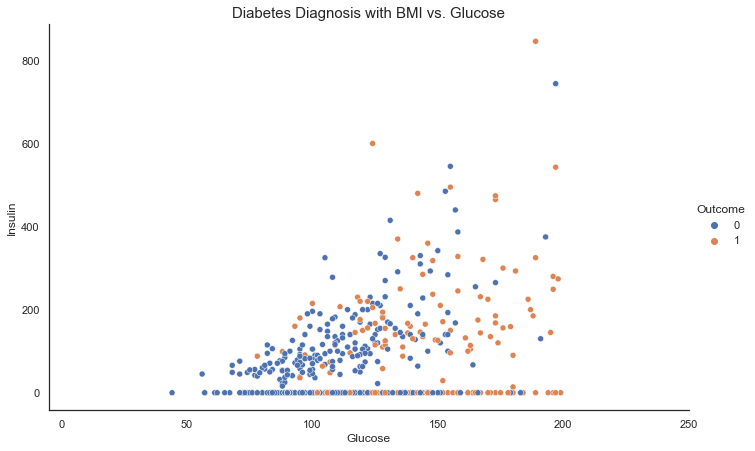

In [101]:
sns.relplot(x="Glucose", y="Insulin", hue="Outcome", data=train, height=6, aspect=1.6)
plt.xlim(-5, 250)
plt.title('Diabetes Diagnosis with BMI vs. Glucose', size=15)

### Exploring Interaction of X Variables
- are there any clear groupings within the independent features?
- are groupings clearer when adding hue for diagnosis?
- what clusters can be created?

### Interaction of Features with Glucose and the Outcome

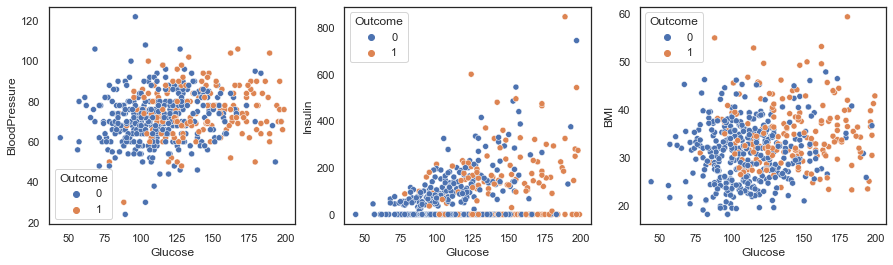

In [31]:
plt.figure(figsize=(15,4))

plt.subplot(131)
sns.scatterplot(x=train.Glucose, y=train.BloodPressure, hue=train.Outcome)

plt.subplot(132)
sns.scatterplot(x=train.Glucose, y=train.Insulin, hue=train.Outcome)

plt.subplot(133)
sns.scatterplot(x=train.Glucose, y=train.BMI, hue=train.Outcome)

### Scatterplots can show if there is a distinction between the variables
- With all, it seems Glucose has the greater effect on the clustering of diabetic outcome
- i.e., Farther right on the Glucose (higher glucose) has more diabetic
- Higher up on the y axis (other feature) does not effect the clustering of diabetic

Text(0.5, 1.0, 'Average Outcome by Age and BMI bins')

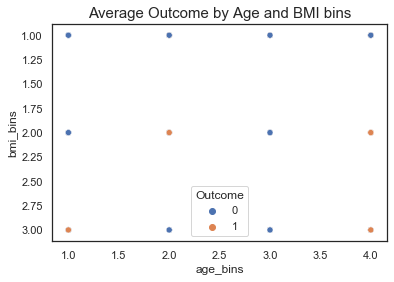

In [103]:
sns.scatterplot(x=train.age_bins, y=train.bmi_bins, hue=train.Outcome)
plt.title('Average Outcome by Age and BMI bins', size=15)

### How to interpret:
Examples
- when age_bin == 1 and bmi_bin == 3, average Outcome == 1 "diabetic"
    - younger patients with higher bmi have an average of diabetic
- when age_bin == 4 and bmi_bin == 1, average Outcome == 0 "non - diabetic"
    - older patients with lower bmi have an average of non-diabetic
- when age_bin == 2 and bmi_bin == 2, average Outcome == 1 "diabetic"

## Visualizing Clusters
- Are there subgroups in the clusters that have a higher rate of daibetes diagnosis? Above the dashed line?

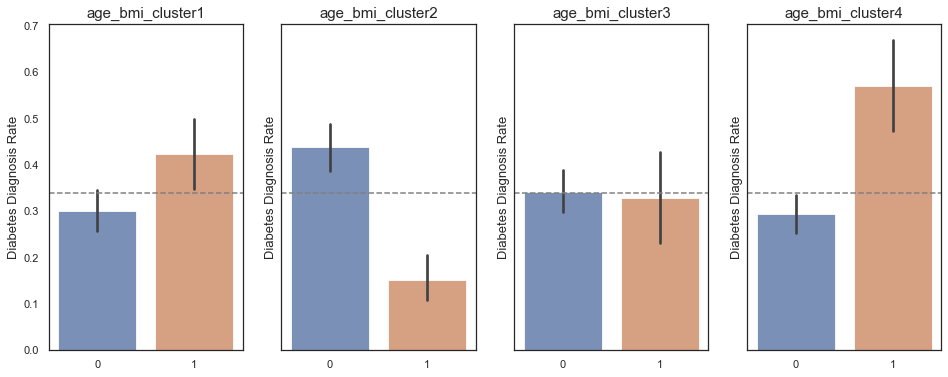

In [33]:
# comparing the dummy variables created from the age_bmi_cluster
features = ['age_bmi_cluster1', 'age_bmi_cluster2', 'age_bmi_cluster3','age_bmi_cluster4']

# overall diagnosis of diabetes on whole train df
diabetic_rate = train.Outcome.mean()

# plotting subgroups diagnosis rate and comparing to overal with dashed line
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'Outcome', data=train, ax=ax[i], alpha=.8)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Diabetes Diagnosis Rate', size=13)
    ax[i].set_title(feature, size=15)
    ax[i].axhline(diabetic_rate, ls='--', color='grey')

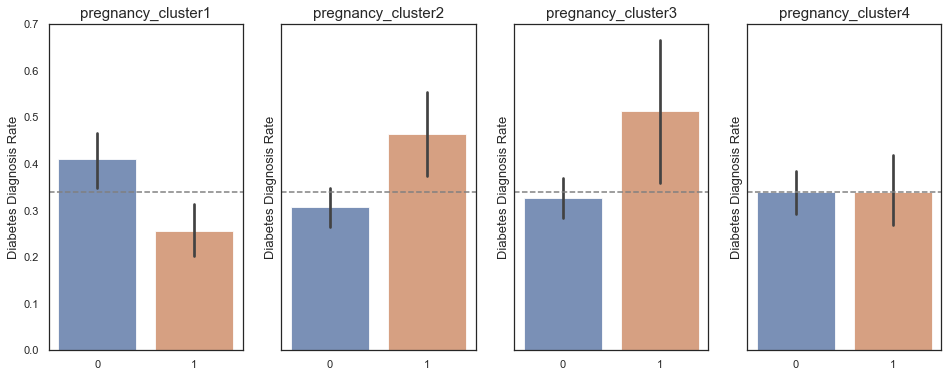

In [34]:
# comparing the dummy variables created from the age_bmi_cluster
features = ['pregnancy_cluster1', 'pregnancy_cluster2', 'pregnancy_cluster3','pregnancy_cluster4']

# overall diagnosis of diabetes on whole train df
diabetic_rate = train.Outcome.mean()

# plotting subgroups diagnosis rate and comparing to overal with dashed line
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'Outcome', data=train, ax=ax[i], alpha=.8)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Diabetes Diagnosis Rate', size=13)
    ax[i].set_title(feature, size=15)
    ax[i].axhline(diabetic_rate, ls='--', color='grey')

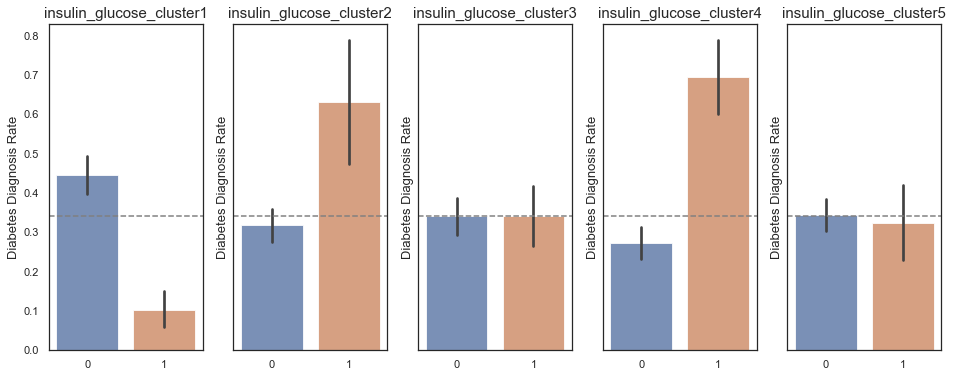

In [35]:
# comparing the dummy variables created from the age_bmi_cluster
features = ['insulin_glucose_cluster1', 'insulin_glucose_cluster2', 'insulin_glucose_cluster3','insulin_glucose_cluster4','insulin_glucose_cluster5']

# overall diagnosis of diabetes on whole train df
diabetic_rate = train.Outcome.mean()

# plotting subgroups diagnosis rate and comparing to overal with dashed line
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'Outcome', data=train, ax=ax[i], alpha=.8)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Diabetes Diagnosis Rate', size=13)
    ax[i].set_title(feature, size=15)
    ax[i].axhline(diabetic_rate, ls='--', color='grey')

### Takeaways
- Glucose has the greatest correlation with diabetes diagnosis
- Statistical testing found Age, BMI, and Pregnancies failed to reject the null hypothesis of "{feature} does not significantly influence diabetes"
- Certain subgroups within clusters have a higher rate of diagnosis than the average

### Next Steps
- can create different clusters
- bin more continuous variables

[Table of Contents](#top)

# Modeling <a class="anchor" id="model"></a>
##### Outcome of patient being diabetic or not is the predictive feature, Y
#### Steps
1. Create the Baseline model for comparison based on most common diagnosis
2. Create models fit to the train df only
3. Validate on top 3 models, tuning hyperparameters
4. Use final top model evaluated on test
5. Determine next steps/conclusions

[Skip to Modeling Summary](#model-summary)

### Baseline

In [36]:
train.Outcome.value_counts()

0    355
1    183
Name: Outcome, dtype: int64

Text(0, 0.5, 'Count of Patients')

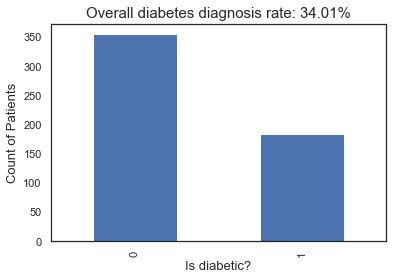

In [37]:
# taking a look at the same barplot again, overall rate of diabetes diagnosis
train.Outcome.value_counts().sort_index().plot.bar()
diabetic_rate = train.Outcome.mean()
plt.title(f"Overall diabetes diagnosis rate: {diabetic_rate:.2%}", size=15)
plt.xlabel('Is diabetic?', size=13)
plt.ylabel('Count of Patients', size=13)

In [38]:
y_train = train[['Outcome']]

In [39]:
# most common diagnosis is non-diabetic, this will be our baseline
y_train['baseline_prediction'] = 0

baseline_accuracy = (y_train.baseline_prediction == train.Outcome).mean()

print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 65.99%


## Creating Classification Models
#### Models Created
- LogisticRegression
- DecisionTree
- RandomForest
- KNN
- RidgeClassifier Model
- SGDClassifier

#### Primary Evaluation Metric
Is it more dangerous to predict diabetic when actually not, or not diabetic when actually diabetic? 
   - It is better to predict Diabetic because a patient not being diagnosed could lead to harm to the patient
   - We want the model to predict 1 better, aka have a higher recall score and precision
       - recall: 
       - TP / (TP + FN)
       - % of acually positive cases that were predicted as positive
       - Optimize for recall when missing actual positive cases is expensive or deadly
       
### Determine What Features to Model on Using:
- SelectKBest
- model.feature_importances_

In [40]:
# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier

# SelectKBest features
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# evaluation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Logistic Regression Model

In [100]:
# does better on all features than when using Top 10 SelectKBest features
X_train = X_train_scaled
y_train = train.Outcome

# create model object
logit = LogisticRegression(C=10)

# fit to train
logit.fit(X_train, y_train)

# predict on train
y_pred = logit.predict(X_train)

#evaluate
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.80


In [43]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[ 2.11347933e-01  5.21904038e+00 -3.20419901e-02  4.01784382e-01
  -4.01759572e-01  4.12192856e+00  1.82297584e+00 -2.31599065e+00
   2.73620345e+00  9.34726427e-01 -3.80222301e-01 -1.40804847e-01
  -3.58543238e-01 -1.93523011e-02  3.80968932e-01 -4.32965520e-01
   4.21396231e-02  4.68849704e-03 -9.15041025e-02  1.22215575e-01
  -6.22351378e-02  2.31439909e-03  7.61211835e-02 -2.15275708e-01
  -6.77589406e-02  4.05233358e-01  6.09546904e-02 -2.12362666e-01]]
Intercept: 
 [-6.11708982]


In [44]:
print(confusion_matrix(y_train, y_pred))

[[314  41]
 [ 66 117]]


In [45]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       355
           1       0.74      0.64      0.69       183

    accuracy                           0.80       538
   macro avg       0.78      0.76      0.77       538
weighted avg       0.80      0.80      0.80       538



## Decision Tree Model

Text(0, 0.5, 'feature')

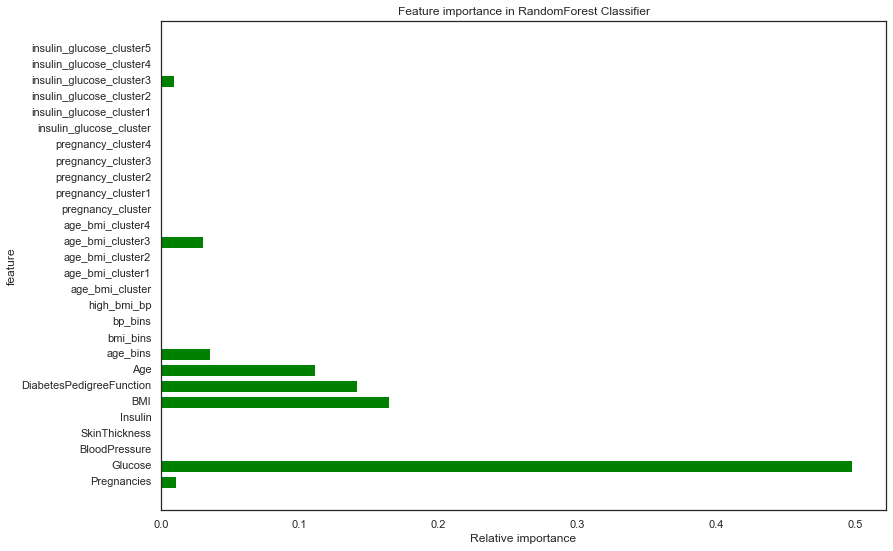

In [46]:
X_train = X_train_scaled

# create the model
clf = DecisionTreeClassifier(max_depth=5, random_state=123)

# fit to train
clf.fit(X_train, y_train)

col = X_train_scaled.columns

#modelname.feature_importance_
y = clf.feature_importances_

#plot
fig, ax = plt.subplots(figsize=(13,9)) 
width = .75 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
plt.barh(ind, y, width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature')

In [47]:
# features to model on
X_train = X_train_scaled[['Glucose','BMI','DiabetesPedigreeFunction','Age']]

# create the model
clf = DecisionTreeClassifier(max_depth=5, random_state=123)

# fit to train
clf.fit(X_train, y_train)

# predict on train
y_pred = clf.predict(X_train)

# evaluate
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.85


In [48]:
confusion_matrix(y_train, y_pred)

array([[327,  28],
       [ 55, 128]])

In [49]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       355
           1       0.82      0.70      0.76       183

    accuracy                           0.85       538
   macro avg       0.84      0.81      0.82       538
weighted avg       0.84      0.85      0.84       538



## Random Forest Model
- visualize feature importance for model
- model on specific features

In [50]:
X_train = X_train_scaled

In [51]:
# create the model
rf = RandomForestClassifier(max_depth=5, random_state=123)

# fit to train
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [52]:
col = X_train_scaled.columns

#modelname.feature_importance_
y = rf.feature_importances_

Text(0, 0.5, 'feature')

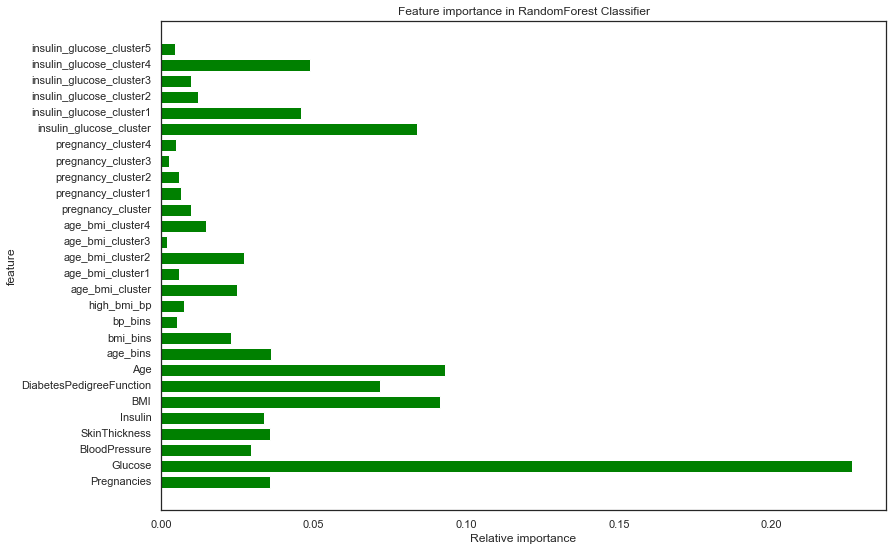

In [53]:
#plot
fig, ax = plt.subplots(figsize=(13,9)) 
width = .75 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
plt.barh(ind, y, width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature')

In [54]:
# features to model on
X_train = X_train_scaled[['Glucose','Age','BMI','insulin_glucose_cluster','DiabetesPedigreeFunction']]

# create the model
rf = RandomForestClassifier(max_depth=5, random_state=123)

# fit to train
rf.fit(X_train, y_train)

# predict on train
y_pred = rf.predict(X_train)

# evaluate
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.85


In [55]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       355
           1       0.82      0.73      0.77       183

    accuracy                           0.85       538
   macro avg       0.84      0.82      0.83       538
weighted avg       0.85      0.85      0.85       538



In [56]:
print(rf.feature_importances_)

[0.36573343 0.18987849 0.19234411 0.11838857 0.1336554 ]


## KNN Model

In [57]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features to select
rfe = RFE(lm, 12)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train.Outcome)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [58]:
# Features elected by SelectKBest
print('SelectKBest Top 12 Features:')
rfe_feature

SelectKBest Top 12 Features:


['Pregnancies',
 'Glucose',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'age_bins',
 'bp_bins',
 'age_bmi_cluster2',
 'age_bmi_cluster3',
 'insulin_glucose_cluster5']

In [59]:
# 10 features have the same rank of 1
rfe.ranking_

array([ 1,  1,  7,  1,  1,  1,  1,  1,  1,  2,  1, 11,  3, 12,  1,  1,  9,
       13, 14,  6, 10, 17, 16, 15,  4,  5,  8,  1])

In [60]:
# select features to model
X_train = X_train_scaled[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction','Age','age_bins','bp_bins','high_bmi_bp','age_bmi_cluster4']]

# create the model
knn = KNeighborsClassifier(n_neighbors=5)

# fit to train
knn.fit(X_train, y_train)

# predict on train
y_pred = knn.predict(X_train)

# evaluate
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.81


In [61]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       355
           1       0.80      0.60      0.69       183

    accuracy                           0.81       538
   macro avg       0.81      0.76      0.78       538
weighted avg       0.81      0.81      0.81       538



## RidgeClassifier Model

In [62]:
# select features to model
X_train = X_train_scaled[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction','Age','age_bins','bp_bins','high_bmi_bp','age_bmi_cluster4']]

# create the model object
clf2 = RidgeClassifier()

# fit to train only
clf2.fit(X_train, y_train)

y_pred = clf2.predict(X_train)

# evaluate with score, returns the mean accuracy on the given test data and labels
print('Accuracy of Ridge classifier on training set:', round(clf2.score(X_train, y_train),2))

Accuracy of Ridge classifier on training set: 0.78


In [63]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       355
           1       0.73      0.56      0.63       183

    accuracy                           0.78       538
   macro avg       0.76      0.73      0.74       538
weighted avg       0.77      0.78      0.77       538



## SGDClassifier Model

In [64]:
# select features to model
X_train = X_train_scaled[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction','Age','age_bins','bp_bins','high_bmi_bp','age_bmi_cluster4']]

clf3 = SGDClassifier(max_iter=1000, tol=1e-3)

clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_train)

print('Accuracy of SGD classifier on training set:', round(clf3.score(X_train, y_train),2))

Accuracy of SGD classifier on training set: 0.73


In [65]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.97      0.83       355
           1       0.81      0.28      0.41       183

    accuracy                           0.73       538
   macro avg       0.77      0.62      0.62       538
weighted avg       0.75      0.73      0.69       538



## Evaluating Top 3 on Validate - Tuning Hyperparameters
1. RandomForest Model at .86 accuracy, .77 recall
2. DecisionTree at .85 accuracy, .77 recall
3. KNN at .82 accuracy, .72 recall

In [66]:
# splitting into y
y_validate = validate[['Outcome']]

### RandomForest on Validate

In [67]:
# features to model on
X_validate = X_validate_scaled[['Glucose','Age','BMI','insulin_glucose_cluster','DiabetesPedigreeFunction']]

# predict on validate
y_pred = rf.predict(X_validate)

# evaluate
print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on validate set: 0.79


In [68]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84        98
           1       0.74      0.64      0.69        55

    accuracy                           0.79       153
   macro avg       0.78      0.76      0.76       153
weighted avg       0.79      0.79      0.79       153



### DecisionTree on Validate

In [69]:
X_validate = X_validate_scaled[['Glucose','BMI','DiabetesPedigreeFunction','Age']]

# predict on validate
y_pred = clf.predict(X_validate)

# evaluate
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.73


In [70]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        98
           1       0.65      0.56      0.60        55

    accuracy                           0.73       153
   macro avg       0.71      0.70      0.70       153
weighted avg       0.73      0.73      0.73       153



### KNN on Validate

In [71]:
# features created model on
X_validate = X_validate_scaled[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction','Age','age_bins','bp_bins','high_bmi_bp','age_bmi_cluster4']]

# predict on train
y_pred = knn.predict(X_validate)

# evaluate
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on validate set: 0.76


In [72]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82        98
           1       0.70      0.60      0.65        55

    accuracy                           0.76       153
   macro avg       0.75      0.73      0.74       153
weighted avg       0.76      0.76      0.76       153



## Evaluating Top Model on Test - Determine if Overfit
- RandomForest did better on recall

In [73]:
# splitting into X and y
# features to model on
X_test = X_test_scaled[['Glucose','Age','BMI','insulin_glucose_cluster','DiabetesPedigreeFunction']]
y_test = test[['Outcome']]

In [74]:
# predict on validate
y_pred = rf.predict(X_test)

# evaluate
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.77


In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82        47
           1       0.75      0.60      0.67        30

    accuracy                           0.77        77
   macro avg       0.76      0.74      0.74        77
weighted avg       0.76      0.77      0.76        77



# Modeling Summary <a class="anchor" id="model-summary"></a>
## All Models Tested on Train
| Model Type          | Hyperparameters         | Features                                                                                                                                                            | Accuracy | Recall on True Positive (Diabetic Predicted Diabetic) |
|---------------------|-------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------|-------------------------------------------------------|
| Logistic Regression | C=10                    | All Features                                                                                                                                                        | 80%      | 64%                                                   |
| Decision Tree       | max_depth=5             | ['Glucose','BMI','DiabetesPedigreeFunction', 'Age']                                                                                                                 | 85%      | 70%                                                   |
| Random Forest       | max_depth=5             | ['Glucose','Age','BMI', 'insulin_glucose_cluster','DiabetesPedigreeFunction']                                                                                       | 85%      | 73%                                                   |
| KNN                 | n_neighbors=5           | ['Pregnancies','Glucose','BloodPressure', 'SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction', 'Age','age_bins','bp_bins','high_bmi_bp','age_bmi_cluster4'] | 81%      | 60%                                                   |
| Ridge Classifier    | None                    | ['Pregnancies','Glucose','BloodPressure', 'SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction', 'Age','age_bins','bp_bins','high_bmi_bp','age_bmi_cluster4'] | 78%      | 56%                                                   |
| SGD Classifier      | max_iter=1000, tol=1e-3 | ['Pregnancies','Glucose','BloodPressure', 'SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction', 'Age','age_bins','bp_bins','high_bmi_bp','age_bmi_cluster4'] | 73%      | 28%                                                   |

## All Models Tested on Validate
| Model Type    | Hyperparameters | Features                                                                                                                                                            | Accuracy | Recall on True Positive (Diabetic Predicted Diabetic) |
|---------------|-----------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------|-------------------------------------------------------|
| Decision Tree | max_depth=5     | ['Glucose','BMI','DiabetesPedigreeFunction', 'Age']                                                                                                                 | 73%      | 56%                                                   |
| Random Forest | max_depth=5     | ['Glucose','Age','BMI', 'insulin_glucose_cluster','DiabetesPedigreeFunction']                                                                                       | 79%      | 64%                                                   |
| KNN           | n_neighbors=5   | ['Pregnancies','Glucose','BloodPressure', 'SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction', 'Age','age_bins','bp_bins','high_bmi_bp','age_bmi_cluster4'] | 76%      | 60%                                                   |

## Final Model Metrics with Train, Validate, and Test: Random Forest

| Model    | RandomForest | (max_depth=5, random_state=123)             | ['Glucose','Age','BMI','insulin_glucose_cluster','DiabetesPedigreeFunction'] |
|----------|--------------|---------------------------------------------|------------------------------------------------------------------------------|
| DF       | Accuracy     | Recall on True Positive (actually diabetic) | Precision on True Positive (actually diabetic)                               |
| Train    | 85%          | 69%                                         | 86%                                                                          |
| Validate | 78%          | 62%                                         | 76%                                                                          |
| Test     | 75%          | 57%                                         | 74%                                                                          |

[Table of Contents](#top)

# Conclusions <a class="anchor" id="fin"></a>
- final model outperforms baseline (64% accuracy, 0% recall)
- most clusters created were not significant for random forest model
- emphasis on modeling performance with True and False positives.
    - diagnosising a patient early on prevents further harm to the patient if medicine/therapy is needed
    - not diagnosing a patient can lead to dangerous levels of Blood Glucose

## Next Steps
- hypothesis testing on more features
- create new clusters and test signifcance in modeling with visuals/hypothesis testing

[Table of Contents](#top)